# Timeseries Transformer

In [69]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413

In [70]:
from __future__ import annotations
import glob
import inspect
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable

In [71]:
sns.set() # Use seaborn themes.

## Environment Setup

This section contains code that is modifies output path locations, random seed, and logging.

In [72]:
DATASET_ROOT = Path('~/research/makassar/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")
PROJECT_ROOT = Path('~/research/makassar').expanduser()
CHECKPOINT_ROOT = PROJECT_ROOT / 'checkpoints'
IMAGE_ROOT = PROJECT_ROOT / 'images'

# Ensure some directories exist.
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
IMAGE_ROOT.mkdir(parents=True, exist_ok=True)

In [73]:
# Set random seeds.
SEED = 0
tf.random.set_seed(SEED) # Only this works on ARC (since tensorflow==2.4).

In [74]:
# Setup logging (useful for ARC systems).
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG) # Must be lowest of all handlers listed below.
while logger.hasHandlers(): logger.removeHandler(logger.handlers[0]) # Clear all existing handlers.

# Custom log formatting.
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')

# Log to STDOUT (uses default formatting).
sh = logging.StreamHandler(stream=sys.stdout)
sh.setLevel(logging.INFO)
logger.addHandler(sh)

# Set Tensorflow logging level.
tf.get_logger().setLevel('ERROR') # 'INFO'

In [75]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
logger.info(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    logger.info(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


## Window Subset Loader

The `WindowGenerator` class operates on `pandas.DataFrame` objects. It accomplishes several tasks:

1. Split the data into contiguous windows.
2. Convert the data into a `tensorflow.Dataset` class for batch loading.

In [76]:
# Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
class WindowGenerator:
    def __init__(self,
        in_seq_len: int,
        out_seq_len: int,
        shift: int,
        columns: list[str],
        in_feat: list[str] = None,
        out_feat: list[str] = None,
        batch_size: int = 32,
        shuffle: bool = False,
        ):
        """Constructs sliding windows of sequential data.

        Args:
            in_seq_len (int): Input sequence length.
            out_seq_len (int): Output (target) sequence length.
            shift (int): Number of indices to skip between elements when traversing window.
            columns (list[str]): List of column names in dataframes.
            in_feat (list[str], optional): Desired subset of input features for window. Defaults to None.
            out_feat (list[str], optional): Desired subset of output features for window. Defaults to None.
            batch_size (int, optional): Batch size. Defaults to 32.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to False.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Preserve sequence information.
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
        self.shift = shift
        self.total_window_len = in_seq_len + shift

        # Setup indexing slices for window extraction.
        self.in_slice = slice(0, self.in_seq_len)
        self.out_slice = slice(self.total_window_len - self.out_seq_len, None)
        self.in_idx = np.arange(self.total_window_len)[self.in_slice]
        self.out_idx = np.arange(self.total_window_len)[self.out_slice]

        # Setup train/val/test column extractors.
        self.col2idx = {name: i for i, name in enumerate(columns)}
        if in_feat is not None:
            self.in_feat = in_feat
            self.in_col_idx = [self.col2idx[col] for col in in_feat]
        else:
            self.in_feat = [columns[i] for i in self.in_col_idx]
            self.in_col_idx = list(range(len(columns)))
        if out_feat is not None:
            self.out_feat = out_feat
            self.out_col_idx = [self.col2idx[col] for col in out_feat]
        else:
            self.out_feat = [columns[i] for i in self.out_col_idx]
            self.out_col_idx = list(range(len(columns)))

    def __repr__(self):
        """String representation of class."""
        return '\n'.join([
            f"Total window length: {self.total_window_len}",
            f"Input indices: {self.in_idx}",
            f"Output indices: {self.out_idx}",
            f"Input features: {self.in_feat}",
            f"Output features: {self.out_feat}",
        ])

    def split_window(self, 
        window: tf.Tensor, # window shape is (batch, seq, feat)
        ) -> tuple[tf.Tensor, tf.Tensor]:
        """Splits a single window of data into input/output seqments.

        Args:
            window (tf.Tensor): Tensor of window data with shape (batch, seq, feat).

        Returns:
            tuple[tf.Tensor, tf.Tensor]: 2-tuple of input/output data segments, where the shapes are:
                - Input window: (batch, in_seq_len, in_feat)
                - Output window: (batch, out_seq_len, out_feat)
        """
        # Decompose input/output sequence from given input window.
        in_seq = tf.stack([window[:, self.in_slice, i] for i in self.in_col_idx], axis=-1)
        out_seq = tf.stack([window[:, self.out_slice, i] for i in self.out_col_idx], axis=-1)

        # Set shape for input/output sequences.
        # Note that dimensions set to `None` are not updated.
        in_seq = tf.ensure_shape(in_seq, (None, self.in_seq_len, None))
        out_seq = tf.ensure_shape(out_seq, (None, self.out_seq_len, None))

        return in_seq, out_seq

    def make_dataset(self, 
        df: pd.DataFrame,
        batch_size: int = None,
        shuffle: bool = None,
        ) -> tf.data.Dataset:
        """Construct a TensorFlow Dataset from given input data frame.

        Datasets load tuples of batched input/output windows with shapes:
            - Input window: (batch, in_seq_len, in_feat)
            - Output window: (batch, out_seq_len, out_feat)

        Note that output windows are generally target sequences.

        Args:
            df (pd.DataFrame): Source data frame.
            batch_size (int, optional): Batch size. Defaults to class value.
            shuffle (bool, optional): Shuffle windows prior to batching. Defaults to class value.

        Returns:
            tf.data.Dataset: Dataset object.
        """
        if batch_size is None:
            batch_size = self.batch_size
        if shuffle is None:
            shuffle = self.shuffle

        # Convert data frame into numpy matrix.
        data = df.to_numpy()

        # Convert data matrix into TensorFlow dataset.
        # dataset = keras.utils.timeseries_dataset_from_array(
        dataset = keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_len,
            sequence_stride=self.shift,
            shuffle=shuffle,
            batch_size=batch_size,
        )

        # Pipe the raw dataset into the window splitting function.
        dataset = dataset.map(self.split_window)

        # Return the dataset.
        return dataset

## Beijing PM2.5 Dataset

In [77]:
def partition_dataset_df(
    df: pd.DataFrame,
    split: tuple[float, float, float] = (0.8, 0.1, 0.1),
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Split a Pandas dataframe into train, validation, and test subsets.

    Args:
        df (pd.DataFrame): Source dataframe.
        split (tuple[float, float, float], optional): Tuple of split ratios. Must sum to 1. Defaults to (0.8, 0.1, 0.1).

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Tuple of train, validation, and test dataframes.
    """
    assert isinstance(split, (list, tuple))
    assert len(split) == 3
    assert sum(split) == 1.0

    # Split dataframe into train/val/test dataframes.
    # Inspiration: https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data
    train_split, val_split, test_split = split # Unpack split tuple.
    n = len(df.index) # Total number of data records.
    df_train = df[:int(n*train_split)].copy()
    df_val = df[int(n*train_split):int(n*(1-test_split))].copy()
    df_test = df[int(n*(1-test_split)):].copy()
    return df_train, df_val, df_test

In [205]:
def load_beijingpm25_df(
    path: str = None,
    split: tuple[float, float, float] = None,
    ) -> pd.DataFrame:
    """Loads Beijing PM2.5 dataset as a pandas dataframe.

    https://archive-beta.ics.uci.edu/ml/datasets/beijing+pm2+5+data

    Dataset features:
        - `No`: (NOT USED) row number
        - `year`: year of data in this row
        - `month`: month of data in this row
        - `day`: day of data in this row
        - `hour`: hour of data in this row
        - `pm2.5`: PM2.5 concentration (ug/m^3)
        - `DEWP`: Dew Point (â„ƒ)
        - `TEMP`: Temperature (â„ƒ)
        - `PRES`: Pressure (hPa)
        - `cbwd`: (NOT USED) Combined wind direction
        - `Iws`: Cumulated wind speed (m/s)
        - `Is`: Cumulated hours of snow
        - `Ir`: Cumulated hours of rain
        - `datetime`: (NOT USED) dynamically generated datetime string
    """
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

    # Set path to current directory if necessary.
    if path is None:
        path = os.getcwd()

    # Convert path to `Path` object.
    if not isinstance(path, Path):
        path = Path(path)

    # Create path if necessary.
    path.mkdir(parents=True, exist_ok=True)

    # Download the dataset if necessary.
    filename = Path(url.rsplit('/', 1)[1]) # Get name of file.
    filepath = (path / filename).expanduser().resolve()
    filepath = keras.utils.get_file(
        fname=filepath,
        origin=url,
        )

    # Load as Pandas DataFrame.
    df = pd.read_csv(filepath)

    # Create single date column from independent year/month/day columns.
    df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])

    # Partition dataframe into train/val/test.
    if split is not None:
        train_df, val_df, test_df = partition_dataset_df(df, split=split)
        return train_df, val_df, test_df

    # Use entire dataset.
    else:
        return df


def load_beijingpm25_ds(
    in_seq_len: int,
    out_seq_len: int,
    shift: int,
    in_feat: list[str],
    out_feat: list[str],
    path: str = None,
    split: tuple[float, float, float] = None,
    batch_size: int = 32,
    shuffle: bool = False,
    drop_columns: list[str] = ['No', 'year', 'month', 'day', 'hour', 'datetime', 'cbwd'],
    drop_nan: bool = True,
    ) -> tf.data.Dataset|tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:

    # Load dataframe.
    df = load_beijingpm25_df(path=path)
    if drop_columns:
        df.drop(columns=drop_columns, inplace=True)
    if drop_nan:
        df.dropna(inplace=True) # Remove NaN.

    # Build window generator.
    columns = df.columns
    wg = WindowGenerator(
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        columns=columns,
        in_feat=in_feat,
        out_feat=out_feat,
        batch_size=batch_size,
        shuffle=shuffle,
    )

    # Partition dataframe into train/val/test.
    if split is not None:
        train_df, val_df, test_df = partition_dataset_df(df, split=split)

        # Reset the indices to zero.
        train_df.reset_index(inplace=True)
        val_df.reset_index(inplace=True)
        test_df.reset_index(inplace=True)

        # Convert train/val/test frames into windowed datasets.
        train_ds = wg.make_dataset(train_df)
        val_ds = wg.make_dataset(val_df)
        test_ds = wg.make_dataset(test_df)

        return train_ds, val_ds, test_ds

    # Use entire dataset.
    else:
        ds = wg.make_dataset(df)
        return ds







df = load_beijingpm25_df(
    path=DATASET_ROOT/'beijing_pm25',
)
print(df.info())

# a, b, c = partition_dataset_df(df)
# print(a.info())
# print(b.info())
# print(c.info())


in_seq_len = 30
out_seq_len = 7
shift = 1
in_feat = [
    # 'pm2.5',
    'DEWP',
    'TEMP',
    'PRES',
    'Iws',
    'Is',
    'Ir',
]
out_feat = [
    'pm2.5',
]
train_ds, val_ds, test_ds = load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=(0.8,0.1,0.1),
    path=DATASET_ROOT/'beijing_pm25',
)
print(train_ds)

logger.info(f"train: {tf.data.experimental.cardinality(train_ds)} batches")
logger.info(f"val: {tf.data.experimental.cardinality(val_ds)} batches")
logger.info(f"test: {tf.data.experimental.cardinality(test_ds)} batches")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        43824 non-null  int64         
 1   year      43824 non-null  int64         
 2   month     43824 non-null  int64         
 3   day       43824 non-null  int64         
 4   hour      43824 non-null  int64         
 5   pm2.5     41757 non-null  float64       
 6   DEWP      43824 non-null  int64         
 7   TEMP      43824 non-null  float64       
 8   PRES      43824 non-null  float64       
 9   cbwd      43824 non-null  object        
 10  Iws       43824 non-null  float64       
 11  Is        43824 non-null  int64         
 12  Ir        43824 non-null  int64         
 13  datetime  43824 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(8), object(1)
memory usage: 4.7+ MB
None
<MapDataset shapes: ((None, 30, 6), (None, 7, 1)), types: (tf.float64

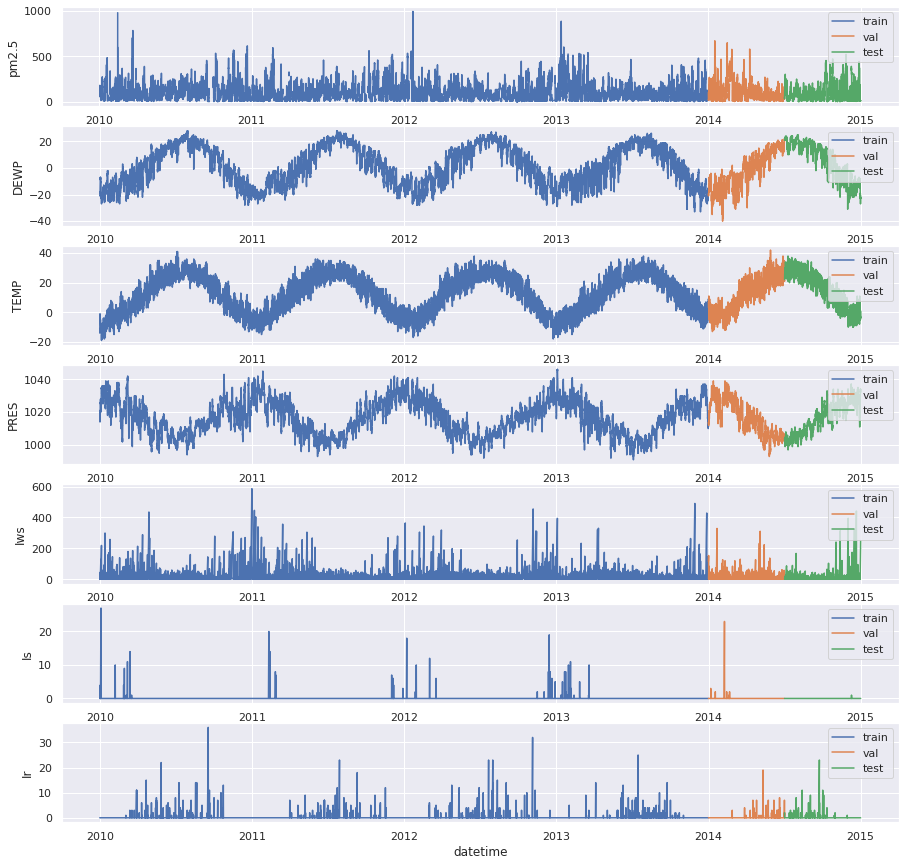

In [206]:
train_df, val_df, test_df = load_beijingpm25_df(
    split=(0.8,0.1,0.1),
    path=DATASET_ROOT/'beijing_pm25',
)

keys = [
    'pm2.5',
    'DEWP',
    'TEMP',
    'PRES',
    'Iws',
    'Is',
    'Ir',
]
fig, axs = plt.subplots(nrows=len(keys), figsize=(15,15))
for i,key in enumerate(keys):
    sns.lineplot(data=train_df, x='datetime', y=key, label='train', ax=axs[i])
    sns.lineplot(data=val_df, x='datetime', y=key, label='val', ax=axs[i])
    sns.lineplot(data=test_df, x='datetime', y=key, label='test', ax=axs[i])
    axs[i].legend(loc='upper right')

## Multi-feature Time2Vec Embedding

Here I build a variation of the `Time2Vec` embedding scheme, originally defined in <https://arxiv.org/abs/1907.05321>, which supports multi-feature input.

In [207]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, embed_dim: int, activation: str = 'sin', **kwargs):
        """Vector embedding representation of time.

        Based on the original concept proposed by Kazemi et al., 2019 (https://arxiv.org/abs/1907.05321).

        This layer operates on a single time step with N feature dimensions. When using this layer for multi-time-step
        datasets, you must pass this layer through a `keras.layers.TimeDistributed` layer to multiplex this for all time steps.

        Note that embedding is done on a per-feature basis. For example, using an input record with 7 features (i.e., shape=(1, 7))
        and an embeddding dimension of 10, the resulting embedding would have 70 dimensions (i.e., shape=(1, 70)). This is because
        each of the 7 features gets a 10-dimensional embedding.

        Args:
            embed_dim (int): Length of the time embedding vector.
            activation (str, optional): Periodic activation function. Possible values are ['sin', 'cos']. Defaults to 'sin'.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim # Embed dimension is k+1.
        self.activation = activation.lower() # Convert to lower-case.

        # Set periodic activation function.
        if self.activation.startswith('sin'):
            self.activation_func = tf.sin
        elif self.activation.startswith('cos'):
            self.activation_func = tf.cos
        else:
            raise ValueError(f'Unsupported periodic activation function "{activation}"')

    def build(self, input_shape: list[int]):

        # Weight and bias term for linear portion (i = 0)
        # of embedding.
        self.w_linear = self.add_weight(
            name='w_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )
        self.b_linear = self.add_weight(
            name='b_linear',
            shape=(input_shape[1],),
            initializer='uniform',
            trainable=True,
        )

        # Weight and bias terms for the periodic
        # portion (1 <= i <= k) of embedding.
        self.w_periodic = self.add_weight(
            name='w_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )
        self.b_periodic = self.add_weight(
            name='b_periodic',
            shape=(1, input_shape[1], self.embed_dim-1,),
            initializer='uniform',
            trainable=True,
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Embed input into linear and periodic feature components.

        Args:
            x (tf.Tensor): Input tensor with shape (sequence_length, feature_size)

        Returns:
            tf.Tensor: Output tensor with shape (sequence_length, feature_size * embed_dim)
        """
        # Linear term (i = 0).
        embed_linear = self.w_linear * x + self.b_linear
        embed_linear = tf.expand_dims(embed_linear, axis=-1) # Reshape to (sequence_length, feature_size, 1)

        # Periodic terms (1 <= i <= k).
        inner = keras.backend.dot(x, self.w_periodic) + self.b_periodic
        embed_periodic = self.activation_func(inner) # (sequence_length, feature_size, embed_dim - 1)

        # Return concatenated linear and periodic features.
        ret = tf.concat([embed_linear, embed_periodic], axis=-1) # (sequence_length, feature_size, embed_dim)
        ret = tf.reshape(ret, (-1, x.shape[1]*self.embed_dim)) # (sequence_length, feature_size * embed_dim)
        return ret

    def compute_output_shape(self, input_shape: tf.TensorShape) -> tf.TensorShape:
        """Determines the output shape for a given input shape.

        Args:
            input_shape (tf.TensorShape): Input shape (sequence_length, feature_size).

        Returns:
            tf.TensorShape: Output shape (sequence_length, feature_size * embed_dim).
        """
        return tf.TensorShape((input_shape[0], input_shape[1]*self.embed_dim))

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'activation': self.activation,
        })
        return config


# Update custom objects dictionary.
keras.utils.get_custom_objects()['Time2Vec'] = Time2Vec



# stock_feat = 7
# seq_len = 128
# embed_dim = 10
# inp = keras.Input(shape=(seq_len, stock_feat))
# logger.info(f"{inp.shape=}")
# x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
# logger.info(f"{x.shape=}")
# x = keras.layers.Concatenate(axis=-1)([inp, x])
# logger.info(f"{x.shape=}")

## Transformer Architecture

In this section, I build a pure-encoder Transformer for time-series regression, based on the original full Transformer architecture defined in <https://arxiv.org/abs/1706.03762>. The model uses the multi-feature `Time2Vec` layer defined above.

### Attention Layers

This implementation currently uses attention layers provided by TensorFlow. See https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.

### Point-wise Feed Forward Network

https://www.tensorflow.org/text/tutorials/transformer#point_wise_feed_forward_network

In [208]:
class PointWiseFeedForwardLayer(keras.layers.Layer):
    def __init__(self, dims: list[int], activation: str = 'gelu', **kwargs):
        """Generic point-wise feed forward layer subnetwork.

        Args:
            dims (list[int]): List of dense layer dimensions. The length of the list determines the number of dimensions. Must be at least 2 dimensions given.
            activation (str, optional): Activation function to use for the first `N-1` dense layers. The final layer has no activation.
        """
        super().__init__(**kwargs)
        assert len(dims) > 1 # Must provide at least 2 dimensions.
        self.dims = dims
        self.n_dim = len(self.dims)
        self.activation = activation

    def build(self, input_shape):
        self.ff_layers = []
        for i, dim in enumerate(self.dims):
            if i < self.n_dim-1:
                self.ff_layers.append(keras.layers.Dense(dim, activation=self.activation))
            else:
                self.ff_layers.append(keras.layers.Dense(dim))

    def call(self, x):
        for i in range(self.n_dim):
            x = self.ff_layers[i](x)
        return x

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'dims': self.dims,
            'activation': self.activation,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['PointWiseFeedForwardLayer'] = PointWiseFeedForwardLayer

### Transformer Encoder Layer

https://www.tensorflow.org/text/tutorials/transformer#encoder_layer

In [209]:
class TransformerEncoderLayer(keras.layers.Layer):
    def __init__(self,
        model_dim: int,
        n_heads: int,
        key_dim: int = None,
        value_dim: int = None,
        ff_dim: int = 2048,
        dropout: float = 0.0,
        **kwargs,
        ):
        """Transformer encoder layer.

        Based on the original concept proposed by Vaswani et al., 2017 (https://arxiv.org/abs/1706.03762).

        Args:
            model_dim (int): Encoder input and output feature dimensions.
            n_heads (int): Number of attention heads.
            key_dim (int, optional): Key dimension. If `None` is specified then defaults to `int(model_dim/n_heads)`. Defaults to `None`.
            value_dim (int, optional): Value dimension. If None is specified the Key dimension will be used. Defaults to `None`.
            ff_dim (int): Dimension of the feed forward sublayer.
            dropout (float, optional): Dropout rate. Defaults to `0.0`.
        """
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.n_heads = n_heads # Number of attention heads.
        if key_dim is None:
            self.key_dim = int(np.ceil(model_dim/n_heads))
        else:
            self.key_dim = key_dim
        if value_dim is None:
            self.value_dim = int(np.ceil(model_dim/n_heads))
        else:
            self.value_dim = value_dim
        self.ff_dim = ff_dim
        self.dropout = dropout

    def build(self, input_shape: tf.TensorShape):

        # First sublayer.
        # Multi-head attention with add and norm.
        self.attn_multi = keras.layers.MultiHeadAttention(
            num_heads=self.n_heads,
            key_dim=self.key_dim,
            value_dim=self.value_dim,
            output_shape=self.model_dim,
        )
        self.attn_multi._build_from_signature(input_shape, input_shape, input_shape)
        self.attn_dropout = keras.layers.Dropout(rate=self.dropout)
        self.attn_add = keras.layers.Add()
        # self.attn_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm = keras.layers.BatchNormalization()

        # Second sublayer.
        # Point-wise feed forward network with add and norm.
        # d_query_feat = input_shape[0][-1] # Query feature size.
        self.ff_net = PointWiseFeedForwardLayer(
            dims=[self.ff_dim, self.model_dim],
            activation='gelu',
        )
        self.ff_dropout = keras.layers.Dropout(rate=self.dropout)
        self.ff_add = keras.layers.Add()
        # self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ff_norm = keras.layers.BatchNormalization()

    def call(self, 
        x: tf.Tensor,
        training: bool = False,
        ) -> tf.Tensor:
        """Encode input using multi-head self-attention mechanisms.

        Args:
            x (tf.Tensor): Batched input sequence into the encoder layer with shape `(batch_size, sequence_length, model_dim)`.
            training (bool, optional): Indicates whether the `call` is meant for training or inference. Defaults to `False`.

        Returns:
            tf.Tensor: Output tensor with shape (batch_size, sequence_length, model_dim)
        """
        # First, do the attention sublayer.
        x_attn = self.attn_multi(x, x, x) # Unpack input as Query, Value, and optional Key.
        x_attn = self.attn_dropout(x_attn, training=training)
        x_attn = self.attn_add([x, x_attn]) # (residual) Add Query matrix with result of attention layer.
        x_attn = self.attn_norm(x_attn, training=training) # Normalize the residual.

        # Second, do the feed forward sublayer.
        x_ff = self.ff_net(x_attn)
        x_ff = self.ff_dropout(x_ff, training=training)
        x_ff = self.ff_add([x_attn, x_ff])
        x_ff = self.ff_norm(x_ff, training=training)

        # Return output of feed forward sublayer.
        return x_ff

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'model_dim': self.model_dim,
            'n_heads': self.n_heads,
            'key_dim': self.key_dim,
            'ff_dim': self.ff_dim,
            'value_dim': self.value_dim,
            'dropout': self.dropout,
        })
        return config

# Update custom objects dictionary.
keras.utils.get_custom_objects()['TransformerEncoderLayer'] = TransformerEncoderLayer

### Model Definition

Here I define a function which builds the entire Transformer using the custom layers defined above.

In [210]:
def build_transformer_encoder_net(
    in_seq_len: int,
    in_feat: int,
    out_feat: int,
    fc_units: list[int], # list of fully-connected dimensions before classifier.
    embed_dim: int,
    n_heads: int,
    key_dim: int = None,
    value_dim: int = None,
    ff_dim: int = 2048,
    dropout: float = 0.0,
    n_encoders: int = 3,
    ):

    # Input sequence of features.
    inp = keras.Input(shape=(in_seq_len, in_feat))
    # Time embedding.
    x = keras.layers.TimeDistributed(Time2Vec(embed_dim))(inp)
    # Combine input with embedding to form attention input features.
    x = keras.layers.Concatenate(axis=-1)([inp, x])
    # Set model dimension, since Time2Vec embedding is dynamic.
    model_dim: int = x.shape[-1]
    # Pass combined featured through cascaded self-attention encoder sublayers.
    for _ in range(n_encoders):
        x = TransformerEncoderLayer(
            model_dim=model_dim,
            key_dim=key_dim,
            n_heads=n_heads,
            ff_dim=ff_dim,
            value_dim=value_dim,
            dropout=dropout,
        )(x)
    # Downsample to the original sequence dimension.
    x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
    x = keras.layers.Dropout(rate=dropout)(x)
    # Fully-connected network before classifier.
    for units in fc_units: 
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=dropout)(x)
    # Classifier.
    x = keras.layers.Dense(units=out_feat, activation='linear')(x)

    # Construct model class and return.
    return keras.Model(inputs=inp, outputs=x)

## Generalized Model Training and Evaluation

In [211]:
def build_model_from_hparams(func):
    """Generalized model build and compile from hyperparameters."""
    def wrapper(hparams: dict, compile_params: dict):
        """Builds model using given hyperparameters for both model and optimizer, and compile parameters for compilation."""
        # Extract paramters needed for the model.
        model_params = {k: hparams[k] for k in inspect.signature(func).parameters if k in hparams}
        # Build model.
        model = func(**model_params)
        # Configure optimizer.
        optim = keras.optimizers.get({
            'class_name': hparams['optim'],
            'config': {
                'lr': hparams['lr'],
            },
        })
        # Compile the model.
        model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])
        return model
    return wrapper

In [212]:
def load_metrics(metrics_path: str):
    """Load model metrics from file."""
    with open(metrics_path, 'r') as f:
        return json.load(f)

def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)

def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path, 
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model

In [216]:
def plot_metric(history: dict, metric: str) -> plt.Figure:
    """Plots model training and validation metric."""
    fig = plt.figure()
    plt.plot(history[metric], label='train')
    plt.plot(history[f"val_{metric}"], label='val')
    plt.xlim(0, len(history[metric])-1)
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend(loc='upper left')
    return fig

Epoch 1/10
261/261 [==============================] - 6s 14ms/step - loss: 13388.9413 - mae: 80.6152 - mape: 602064.5270 - val_loss: 22268.2910 - val_mae: 95.5394 - val_mape: 170.8074
Epoch 2/10
261/261 [==============================] - 3s 12ms/step - loss: 4029.3633 - mae: 42.4974 - mape: 1170493.2902 - val_loss: 7383.2100 - val_mae: 58.5417 - val_mape: 82.1578
Epoch 3/10
261/261 [==============================] - 3s 12ms/step - loss: 3867.1206 - mae: 41.5394 - mape: 1381894.9982 - val_loss: 1648.3889 - val_mae: 26.5662 - val_mape: 47.1393
Epoch 4/10
261/261 [==============================] - 3s 12ms/step - loss: 3898.5617 - mae: 41.4688 - mape: 1260885.4000 - val_loss: 1918.9333 - val_mae: 29.2634 - val_mape: 49.7133
Epoch 5/10
261/261 [==============================] - 3s 12ms/step - loss: 3881.8777 - mae: 41.0559 - mape: 995990.9956 - val_loss: 2289.1018 - val_mae: 32.4161 - val_mape: 49.0706
Epoch 6/10
261/261 [==============================] - 3s 12ms/step - loss: 3808.6067 - ma

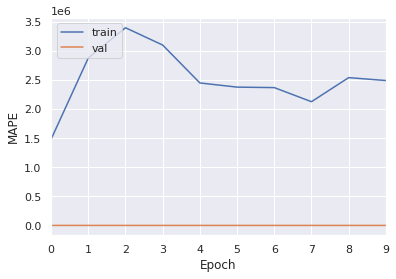

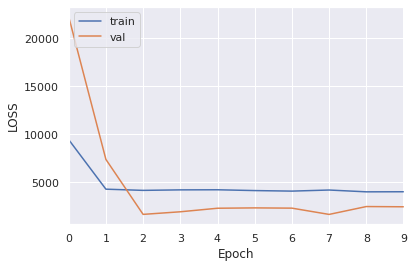

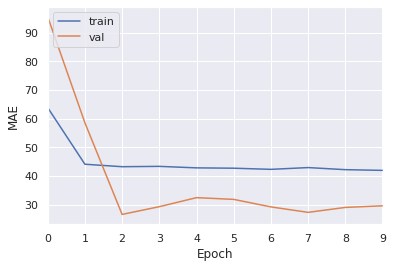

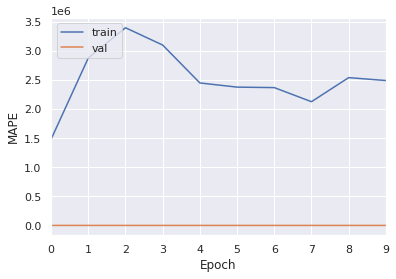

In [221]:
in_seq_len = 30
out_seq_len = 7
shift = 1
in_feat = [
    # 'pm2.5',
    'DEWP',
    # 'TEMP',
    # 'PRES',
    # 'Iws',
    # 'Is',
    # 'Ir',
]
out_feat = [
    # 'pm2.5',
    'DEWP',
]
train_ds, val_ds, test_ds = load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=(0.8,0.1,0.1),
    shuffle=False,
    path=DATASET_ROOT/'beijing_pm25',
    batch_size=128,
)

# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)
# Model hyperparameters.
hparams = dict(
    in_seq_len=in_seq_len,
    in_feat=len(in_feat),
    out_feat=len(out_feat),
    fc_units=[64,64],
    embed_dim=4,
    n_heads=8,
    ff_dim=2048,
    dropout=0.1,
    n_encoders=3,
    optim='adam',
    lr=1e-3,
)

# Create model building function.
builder = build_model_from_hparams(build_transformer_encoder_net)

# Build the model.
model = builder(hparams=hparams, compile_params=compile_params)

# Train the model.
epochs = 10
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=None,
    verbose=1,
)
print(history.history)

plot_metric(history.history, 'loss')
plot_metric(history.history, 'mae')
plot_metric(history.history, 'mape')